In [1]:
import dask
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from matplotlib import cm
import copy
import astropy
import hdbscan
import pandas as pd

from astropy.io import fits

In [2]:
y = pd.read_csv('rcsed_iGrID.csv')

In [3]:
sdss_indx = list(y[~y.iGrID.isna()].index)

In [4]:
y = y.loc[sdss_indx,:].to_numpy().flatten()

In [5]:
sdss_labels = pd.Series(y)

In [8]:
# hdul = fits.open('http://gal-03.sai.msu.ru/~vtoptun/photometry/rcsed_v2_clean.fits', memmap=astropy.io.fits.Conf.use_memmap.defaultvalue, lazy_load_hdus=True)
# hdul = fits.open('http://gal-03.sai.msu.ru/~vtoptun/redshift/rcsed_v2.fits')
hdul = fits.open('rcsed_v2_clean.fits', memmap=astropy.io.fits.Conf.use_memmap.defaultvalue, lazy_load_hdus=True)

In [9]:
cols = hdul[1].columns

In [10]:
data = hdul[1].data[sdss_indx]

In [11]:
hdul.close()
del hdul

In [12]:
DATA = pd.DataFrame(np.array(data).byteswap().newbyteorder()) 

In [13]:
del data

In [15]:
DATA.drop(labels=['ind'], axis = 1, inplace=True)

In [16]:
DATA.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401148 entries, 0 to 401147
Data columns (total 558 columns):
ra                           401148 non-null float64
dec                          401148 non-null float64
z_sdss                       401148 non-null float64
zerr_sdss                    401147 non-null float64
specObjID_sdss               401148 non-null float64
bestObjID_sdss               401148 non-null int64
plate_sdss                   401148 non-null int16
mjd_sdss                     401148 non-null int32
fiberID_sdss                 401148 non-null int16
z_2df                        16600 non-null float32
q_z_2df                      401148 non-null int32
SeqNum_2df                   401148 non-null object
z_6df                        3514 non-null float64
quality_6df                  401148 non-null int16
targetname_6df               401148 non-null object
specid_6df                   401148 non-null int32
recno_uzc                    401148 non-null int32
z_uzc   

In [20]:
DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401148 entries, 0 to 401147
Columns: 558 entries, ra to modelMagErr_g
dtypes: float32(312), float64(217), int16(7), int32(9), int64(1), int8(4), object(6), uint8(2)
memory usage: 1.2+ GB


In [21]:
data_float = DATA.select_dtypes(include=['float32', 'float64'])
data_int = DATA.select_dtypes(include=['int8','int16','int32','int64','uint8'])

converted_float = data_float.apply(pd.to_numeric,downcast='float')
# converted_int = data_int.apply(pd.to_numeric,downcast='unsigned')

del data_float #, data_int

In [22]:
DATA = pd.concat([converted_float, data_int],axis=1)

del converted_float #converted_int

In [23]:
DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401148 entries, 0 to 401147
Columns: 552 entries, ra to wigglez_photo
dtypes: float32(529), int16(7), int32(9), int64(1), int8(4), uint8(2)
memory usage: 834.0 MB


In [24]:
# Удаляем аномальные значения из таблицы

DATA.replace([
    -2147483648,
    -9223372036854775808,
    -32768,
     255,
    -999999488.0,
     99.0,
     0.0,
     -99.0,
     9999.0,
     -999.0,
     0.05299999937415123,
     float('inf'),
     3.5,
     -9999.0,
     4.619999885559082,
     0.05000000074505806,
     70.0,
     4.0,
     179.96949768066406,
     0.06128999963402748,
     24.6346492767334,
     8.400000e+01, 
     3.960000e+00
             ], np.nan, inplace=True)

In [25]:
DATA.dropna(axis=1,
    how='all',
    thresh=None,
    subset=None,
    inplace=True)

In [26]:
DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401148 entries, 0 to 401147
Columns: 539 entries, ra to NQ_gama
dtypes: float32(522), float64(15), int64(2)
memory usage: 850.8 MB


In [27]:
DATA.shape

(401148, 539)

In [28]:
DATA.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401148 entries, 0 to 401147
Data columns (total 539 columns):
ra                           401148 non-null float32
dec                          401148 non-null float32
z_sdss                       401148 non-null float32
zerr_sdss                    401147 non-null float32
specObjID_sdss               401148 non-null float32
z_2df                        16600 non-null float32
z_6df                        3514 non-null float32
z_uzc                        9483 non-null float32
z_cfa                        4709 non-null float32
z_hectospec                  1925 non-null float32
z_lamost                     50768 non-null float32
z_err_lamost                 49500 non-null float32
Z_deep2                      8 non-null float32
Z_deep3                      3 non-null float32
z_wigglez                    38 non-null float32
Z_gama                       7603 non-null float32
E_bv                         401148 non-null float32
A_u_sdss      

In [29]:
pd.set_option('max_columns', None)
DATA.head()

,ra,dec,z_sdss,zerr_sdss,specObjID_sdss,z_2df,z_6df,z_uzc,z_cfa,z_hectospec,z_lamost,z_err_lamost,Z_deep2,Z_deep3,z_wigglez,Z_gama,E_bv,A_u_sdss,A_g_sdss,A_r_sdss,A_i_sdss,A_z_sdss,A_g_des,A_r_des,A_i_des,A_z_des,A_u_skymapper,A_v_skymapper,A_g_skymapper,A_r_skymapper,A_i_skymapper,A_z_skymapper,A_Y_ukidss,A_J_ukidss,A_H_ukidss,A_K_ukidss,A_Z_viking,A_Y_viking,A_J_viking,A_H_viking,A_ks_viking,A_g_panstarrs,A_r_panstarrs,A_i_pansatrrs,A_z_panstarrs,A_y_panstarrs,A_w1_wise,A_w2_wise,A_w3_wise,A_w4_wise,A_NUV_galex,A_FUV_galex,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,fibermag_u_sdss,fibermag_g_sdss,fibermag_r_sdss,fibermag_i_sdss,fibermag_z_sdss,fibermagerr_u_sdss,fibermagerr_g_sdss,fibermagerr_r_sdss,fibermagerr_i_sdss,fibermagerr_z_sdss,fiber2mag_u_sdss,fiber2mag_g_sdss,fiber2mag_r_sdss,fiber2mag_i_sdss,fiber2mag_z_sdss,fiber2magerr_u_sdss,fiber2magerr_g_sdss,fiber2magerr_r_sdss,fiber2magerr_i_sdss,fiber2magerr_z_sdss,petromag_u_sdss,petromag_g_sdss,petromag_r_sdss,petromag_i_sdss,petromag_z_sdss,petromagerr_u_sdss,petromagerr_g_sdss,petromagerr_r_sdss,petromagerr_i_sdss,petromagerr_z_sdss,petror50_u_sdss,petror50_g_sdss,petror50_r_sdss,petror50_i_sdss,petror50_z_sdss,magerr_petro_g_des,magerr_petro_r_des,magerr_petro_i_des,magerr_petro_z_des,magerr_petro_y_des,mag_petro_g_des,mag_petro_r_des,mag_petro_i_des,mag_petro_z_des,mag_petro_y_des,petro_radius_g_des,petro_radius_r_des,petro_radius_i_des,petro_radius_z_des,petro_radius_y_des,mag_aper_8_g_des,magerr_aper_8_g_des,mag_aper_8_r_des,magerr_aper_8_r_des,mag_aper_8_i_des,magerr_aper_8_i_des,mag_aper_8_z_des,magerr_aper_8_z_des,mag_aper_8_y_des,magerr_aper_8_y_des,mag_auto_g_des,magerr_auto_g_des,mag_auto_r_des,magerr_auto_r_des,mag_auto_i_des,magerr_auto_i_des,mag_auto_z_des,magerr_auto_z_des,mag_auto_y_des,magerr_auto_y_des,mag_aper_8_g_dered,mag_aper_8_r_dered,mag_aper_8_i_dered,mag_aper_8_z_dered,mag_aper_8_y_dered,mag_auto_g_dered,mag_auto_r_dered,mag_auto_i_dered,mag_auto_z_dered,mag_auto_y_dered,kron_radius_g_des,kron_radius_r_des,kron_radius_i_des,kron_radius_z_des,kron_radius_y_des,umag_kids,e_umag_kids,gmag_kids,e_gmag_kids,rmag_kids,e_rmag_kids,imag_kids,e_imag_kids,u_petro_skymapper,e_u_petro_skymapper,v_petro_skymapper,e_v_petro_skymapper,g_petro_skymapper,e_g_petro_skymapper,r_petro_skymapper,e_r_petro_skymapper,i_petro_skymapper,e_i_petro_skymapper,z_petro_skymapper,e_z_petro_skymapper,JPETROMAG_uhs,JPETROMAGERR_uhs,JAPERMAG3_uhs,JAPERMAG3ERR_uhs,JAPERMAG4_uhs,JAPERMAG4ERR_uhs,JAPERMAG6_uhs,JAPERMAG6ERR_uhs,YPETROMAG_ukidss,YPETROMAGERR_ukidss,YAPERMAG3_ukidss,YAPERMAG3ERR_ukidss,YAPERMAG4_ukidss,YAPERMAG4ERR_ukidss,YAPERMAG6_ukidss,YAPERMAG6ERR_ukidss,JPETROMAG_ukidss,JPETROMAGERR_ukidss,JAPERMAG3_ukidss,JAPERMAG3ERR_ukidss,JAPERMAG4_ukidss,JAPERMAG4ERR_ukidss,JAPERMAG6_ukidss,JAPERMAG6ERR_ukidss,J_1PETROMAG_ukidss,J_1PETROMAGERR_ukidss,J_1APERMAG3_ukidss,J_1APERMAG3ERR_ukidss,J_1APERMAG4_ukidss,J_1APERMAG4ERR_ukidss,J_1APERMAG6_ukidss,J_1APERMAG6ERR_ukidss,J_2PETROMAG_ukidss,J_2PETROMAGERR_ukidss,J_2APERMAG3_ukidss,J_2APERMAG3ERR_ukidss,J_2APERMAG4_ukidss,J_2APERMAG4ERR_ukidss,J_2APERMAG6_ukidss,J_2APERMAG6ERR_ukidss,HPETROMAG_ukidss,HPETROMAGERR_ukidss,HAPERMAG3_ukidss,HAPERMAG3ERR_ukidss,HAPERMAG4_ukidss,HAPERMAG4ERR_ukidss,HAPERMAG6_ukidss,HAPERMAG6ERR_ukidss,KPETROMAG_ukidss,KPETROMAGERR_ukidss,KAPERMAG3_ukidss,KAPERMAG3ERR_ukidss,KAPERMAG4_ukidss,KAPERMAG4ERR_ukidss,KAPERMAG6_ukidss,KAPERMAG6ERR_ukidss,EBV_ukidss,AY_ukidss,AH_ukidss,AK_ukidss,yPetroMag_vhs,yPetroMagErr_vhs,yAperMag3_vhs,yAperMag3Err_vhs,yAperMag4_vhs,yAperMag4Err_vhs,yAperMag6_vhs,yAperMag6Err_vhs,jPetroMag_vhs,jPetroMagErr_vhs,jAperMag3_vhs,jAperMag3Err_vhs,jAperMag4_vhs,jAperMag4Err_vhs,jAperMag6_vhs,jAperMag6Err_vhs,hPetroMag_vhs,hPetroMagErr_vhs,hAperMag3_vhs,hAperMag3Err_vhs,hAperMag4_vhs,hAperMag4Err_vhs,hAperMag6_vhs,hAperMag6Err_vhs,ksPetroMag_vhs,ksPetroMagErr_vhs,ksAperMag3_vhs,ksAperMag3Err_vhs,ksAperMag4_vhs,ksAperMag4Err_vhs,ksAperMag6_vhs,ksAperMag6Er

**Наблюдения:**
- в некоторых колонках,  в которых присутствуют все значния есть очень странные значения вроде "-2147483648" или "-32768" и другие

In [30]:
#    Здесь мы создадим датафрейм с наиболее 
#       частотными значениями по каждому из столбцов

top_values = []

for col in DATA.columns[1:]:
    vc = DATA[col].value_counts(ascending=False).head(1)
    top_values.append([vc.name, vc.index[0], vc[vc.index[0]]])
    
anomaly = pd.DataFrame(data=top_values, columns = ['column_name', 'anomaly_value', 'value_counts'])

In [31]:
# Здесь мы создаем колонку с количеством
#  ненулевых значений в каждом из столбцов таблицы
#     DATA, начиная с ra

not_nan = []

for col in DATA.columns[1:]:
    not_nan.append((~DATA[col].isna()).sum())
    
not_nan = pd.Series(not_nan)

In [32]:
# Дополним получившийся датафрейм столбцом, показывающим,
# какую долю от длины всего столбца занимает каждое аномальное значение

import copy

top_values_data = copy.copy(anomaly)

top_values_data['percent_total'] = (top_values_data.value_counts / len(DATA)).round(3)
top_values_data['percent_not_nan'] = (top_values_data.value_counts / not_nan).round(3)

In [33]:
# Выведем на экран получившйся датафрейм

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(top_values_data.sort_values(by='percent_not_nan', ascending=False))

### Анализ данных на основе таблицы top_values_data

Таблица **top_values_data** содержит в себе следующие столбцы:
- **column_name**   -   названия столбцов таблицы **DATA**

- **anomaly_value**   -   наиболее частотные значения столбцов таблицы **DATA**

- **value_counts**   -   количество раз, которое *anomaly_value* встречается в столбце таблицы **DATA**

- **percent_total**   -   доля *anomaly_value* от всего объема столбца таблицы **DATA**

- **percent_not_nan**   -   доля *anomaly_value* от non-null объема столбца таблицы **DATA**

В ячейке ниже показано, сколько столбцов таблицы **DATA** содержат более **90% и т.д.** аномальных значений от общего количества non-null значений столбца. Оказывается, что около трети столбцов (162) содержат таки аномалий больше, чем **10%**.

**! Нужно понять, какой порог считать допустимым.**

**! Остальные можно отбросить.**


In [34]:
#     Добавим столбец non_null_part, показываающий 
#     какую часть от величины столбца составляют ненулевые значения

top_values_data['non_null_part'] = (not_nan / len(DATA)).round(3)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(top_values_data.sort_values(by='non_null_part', ascending=True))

In [35]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(top_values_data.sort_values(by='anomaly_value', ascending=False))

In [36]:
# # Выведем на экран получившйся датафрейм

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(top_values_data.sort_values(by='value_counts', ascending=False))

In [37]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(DATA.describe(include='object'))

In [38]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(DATA.describe())

In [39]:
DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401148 entries, 0 to 401147
Columns: 539 entries, ra to NQ_gama
dtypes: float32(522), float64(15), int64(2)
memory usage: 850.8 MB


In [40]:
# Найдем колонки, в которых аномальные значения
#     составляют не менее 90% от всех ненулевых значений столбца 

# percent_not_nan - доля anomaly_value от non-null объема столбца таблицы DATA
# non_null_part - доля ненулевых значений  от величины столбца 

columns_drop = top_values_data[(top_values_data['percent_not_nan']*top_values_data['non_null_part'] > 0.2) #0.2)
                               |(top_values_data['non_null_part'] < 0.8) #8)
                               |(top_values_data['anomaly_value']==float('inf'))].column_name 

In [41]:
del top_values_data

In [42]:
# Удалим колонки из DATA, в которых анамальные значения
#     составляют о не менее 90% от всех ненулевых значений столбца 

DATA.drop(labels=columns_drop, axis = 1, inplace=True)

Кажется, что мы очистили таблицу от всех столбцов, несущих мало информации, так как они содержали большое количество NaN или аномальных значений.

**Следующим нашим шагом** будет использование **IterativeImputer** чтобы заполнить оставшиеся пустые значения таблицы.

К новой заполненной таблице можно будет применить методы понижения разверности: VAE, t-SNE, PCA и др.

А далее уже кластеризировать.

In [43]:
# DATA.info()

In [44]:
DATA = DATA.select_dtypes(include=['float32', 'float64']).apply(pd.to_numeric,downcast='float')

In [45]:
DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401148 entries, 0 to 401147
Columns: 117 entries, ra to fiberID_sdss
dtypes: float32(117)
memory usage: 179.0 MB


In [46]:
DATA_columns = DATA.columns

In [47]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [48]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

x = imputer.fit_transform(DATA)

In [49]:
# del DATA

In [50]:
x.shape

(401148, 117)

In [51]:
from sklearn.decomposition import TruncatedSVD

/home/azarodnyuk/.local/lib/python3.5/site-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/home/azarodnyuk/.local/lib/python3.5/site-packages/sklearn/decomposition/_truncated_svd.py:194: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


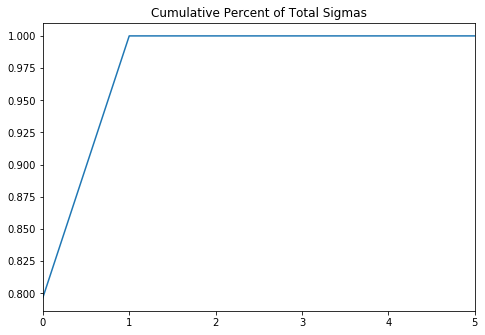

In [52]:
tsvd = TruncatedSVD(n_components=x.shape[1]-1, algorithm='randomized', n_iter=5, random_state=42)

S = tsvd.fit_transform(x)
sigmas = tsvd.singular_values_;

fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
axes.plot(np.cumsum(sigmas) / sum(sigmas)); 
axes.set_title('Cumulative Percent of Total Sigmas');
axes.set_xlim(0,5);

In [53]:
min_cluster_size = 24 #24

tsvd = TruncatedSVD(n_components=1, algorithm='randomized', n_iter=5, random_state=42)
x_new = tsvd.fit_transform(x)

hdbScan = hdbscan.hdbscan_.HDBSCAN( min_cluster_size=min_cluster_size, #24 #26,
                                    min_samples=11, #11
                                    cluster_selection_epsilon=0.0,
                                    metric='euclidean',
                                    alpha=4.5, #4.5,
                                    p=None,
                                    algorithm='boruvka_balltree',
                                    leaf_size=90, #90,
                                    #'boruvka_balltree',
                                    # * ``generic``
                                    # * ``prims_kdtree``
                                    # * ``prims_balltree``
                                    # * ``boruvka_kdtree``
                                    # * ``boruvka_balltree``
                                    approx_min_span_tree=True,
                                    gen_min_span_tree=True, #True,
                                    core_dist_n_jobs=4,
                                    cluster_selection_method='leaf', #leaf
                                    allow_single_cluster=False,
                                    prediction_data=False,
                                    match_reference_implementation=False).fit(x_new)

rcsed_labels = hdbScan.labels_
for i in range(len(rcsed_labels)):
    if rcsed_labels[i]==-1:
        rcsed_labels[i]=i+5000000

true = y
pred = rcsed_labels

pd_true = pd.Series(true)
pd_pred = pd.Series(pred)

greater_min_cluster_size = list(pd_pred.value_counts()
[pd_pred.value_counts()>= min_cluster_size].index)
idx_min_cluster_size = list(pd_pred[pd_pred.isin(greater_min_cluster_size)].index)

# fms = round(sklearn.metrics.fowlkes_mallows_score(true[idx_min_cluster_size], pred[idx_min_cluster_size]),5)
# ars = round(sklearn.metrics.adjusted_rand_score(true[idx_min_cluster_size], pred[idx_min_cluster_size]),5)
# nmi = round(sklearn.metrics.normalized_mutual_info_score(true[idx_min_cluster_size], pred[idx_min_cluster_size]),5)

# print('FMS = ', fms)
# print('ARS = ', ars)
# print('NMI = ', nmi)

print(len(idx_min_cluster_size))

# pd_pred = pd.Series(pred)
outliers = list(pd_pred.value_counts()
[pd_pred.value_counts() == 1].index)
idx_outliers = list(pd_pred[pd_pred.isin(outliers)].index)


hdbScan = hdbscan.hdbscan_.HDBSCAN( min_cluster_size=2, #2,
                                    min_samples=3, #3,
                                    cluster_selection_epsilon=0.0,
                                    metric='euclidean',
                                    alpha=4.5,
                                    p=None,
                                    algorithm='best', #'best'
                                    leaf_size=90, #90,
                                    #'boruvka_balltree',
                                    # * ``generic``
                                    # * ``prims_kdtree``
                                    # * ``prims_balltree``
                                    # * ``boruvka_kdtree``
                                    # * ``boruvka_balltree``
                                    approx_min_span_tree=True,
                                    gen_min_span_tree=True, #True,
                                    core_dist_n_jobs=4,
                                    cluster_selection_method='eom', #eom
                                    allow_single_cluster=False,
                                    prediction_data=False,
                                    match_reference_implementation=False).fit(x_new[idx_outliers])

rcsed_labels_1 = hdbScan.labels_
for i in range(len(rcsed_labels_1)):
    if rcsed_labels_1[i]==-1:
        rcsed_labels_1[i]=i+10000000

# fms = round(sklearn.metrics.fowlkes_mallows_score(true[idx_outliers], rcsed_labels_1),5)
# ars = round(sklearn.metrics.adjusted_rand_score(true[idx_outliers], rcsed_labels_1),5)
# nmi = round(sklearn.metrics.normalized_mutual_info_score(true[idx_outliers], rcsed_labels_1),5)

# print('FMS = ', fms)
# print('ARS = ', ars)
# print('NMI = ', nmi)

rcsed_labels[idx_outliers] = rcsed_labels_1+15000000

fms = round(sklearn.metrics.fowlkes_mallows_score(true, rcsed_labels),5)
ars = round(sklearn.metrics.adjusted_rand_score(true, rcsed_labels),5)
nmi = round(sklearn.metrics.normalized_mutual_info_score(true, rcsed_labels),5)

print('FMS = ', fms)
print('ARS = ', ars)
print('NMI = ', nmi)


/home/azarodnyuk/.local/lib/python3.5/site-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/home/azarodnyuk/.local/lib/python3.5/site-packages/sklearn/decomposition/_truncated_svd.py:194: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


329217
FMS =  0.11897
ARS =  0.09462
NMI =  0.83957


In [54]:
pd.Series(pred).value_counts()#.value_counts()

130         218
292         216
136         203
1091        201
1143        189
356         188
1125        187
587         186
714         181
177         181
1722        181
423         176
652         171
139         171
212         169
1113        165
1124        165
176         162
51          161
2465        159
121         156
185         156
339         156
41          155
1528        155
5632        154
298         154
133         154
1234        153
3832        152
           ... 
25014669      1
25010575      1
25003059      1
25028415      1
25061199      1
25027942      1
25004597      1
25056078      1
25043776      1
25027384      1
25025665      1
25027718      1
25017485      1
25062679      1
25048348      1
25062647      1
25046271      1
25003615      1
25005963      1
25002548      1
25017741      1
25044254      1
25055310      1
25015897      1
25040967      1
25024085      1
25014322      1
25032273      1
25042476      1
25063178      1
Length: 21254, dtype: in

In [55]:
pd.Series(true).value_counts()#.value_counts()

149473.0    896
153084.0    765
39456.0     567
176804.0    396
42643.0     277
112271.0    250
30885.0     236
160410.0    229
127065.0    227
13370.0     220
20266.0     214
20078.0     187
101773.0    181
176164.0    179
191838.0    174
127066.0    170
126645.0    169
16435.0     162
101211.0    156
81481.0     154
107331.0    149
183718.0    146
150207.0    143
40250.0     141
82182.0     141
152483.0    140
45917.0     137
10476.0     134
19966.0     129
180785.0    128
           ... 
34000.0       1
207784.0      1
207783.0      1
125642.0      1
207782.0      1
51949.0       1
207798.0      1
103907.0      1
207807.0      1
207813.0      1
207812.0      1
207811.0      1
45021.0       1
125640.0      1
207810.0      1
207809.0      1
25976.0       1
30791.0       1
98090.0       1
207799.0      1
18126.0       1
207806.0      1
87366.0       1
207805.0      1
51951.0       1
207803.0      1
207802.0      1
207801.0      1
25975.0       1
192549.0      1
Length: 229381, dtype: i